# Enhanced Machine Learning Model Training for Real Estate RENT Pricing

This notebook provides an enhanced environment to train and evaluate multiple regression models with:
- Improved feature engineering
- Data leakage prevention
- Hyperparameter tuning
- Cross-validation
- Comprehensive model evaluation

## 1. Import Required Libraries

In [45]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load and Explore Data

In [46]:
# Load the dataset
data_path = Path("data/processed/sale_processed.csv") 
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
print(df.describe())

Dataset shape: (12901, 18)

First few rows:
              region      price  price_normalized  surface  rooms  bathrooms  \
0             Mornag   750000.0          0.202561    527.0      5          5   
1  Boumhel Bassatine  1690000.0          1.920106    550.0      6          6   
2            Le Kram   682500.0          0.079227    161.0      3          3   
3           La Marsa   682500.0          0.079227    224.0      4          3   
4    Nouvelle Medina   180000.0         -0.838928     61.0      1          1   

  property_type  property_type_cluster price_segment  has_piscine  has_garage  \
0         Villa                      1        Medium        False        True   
1         Villa                      1          High        False        True   
2   Appartement                      0          High         True       False   
3   Appartement                      0          High        False       False   
4   Appartement                      2           Low         True     

## 3. Data Quality Analysis & Outlier Detection

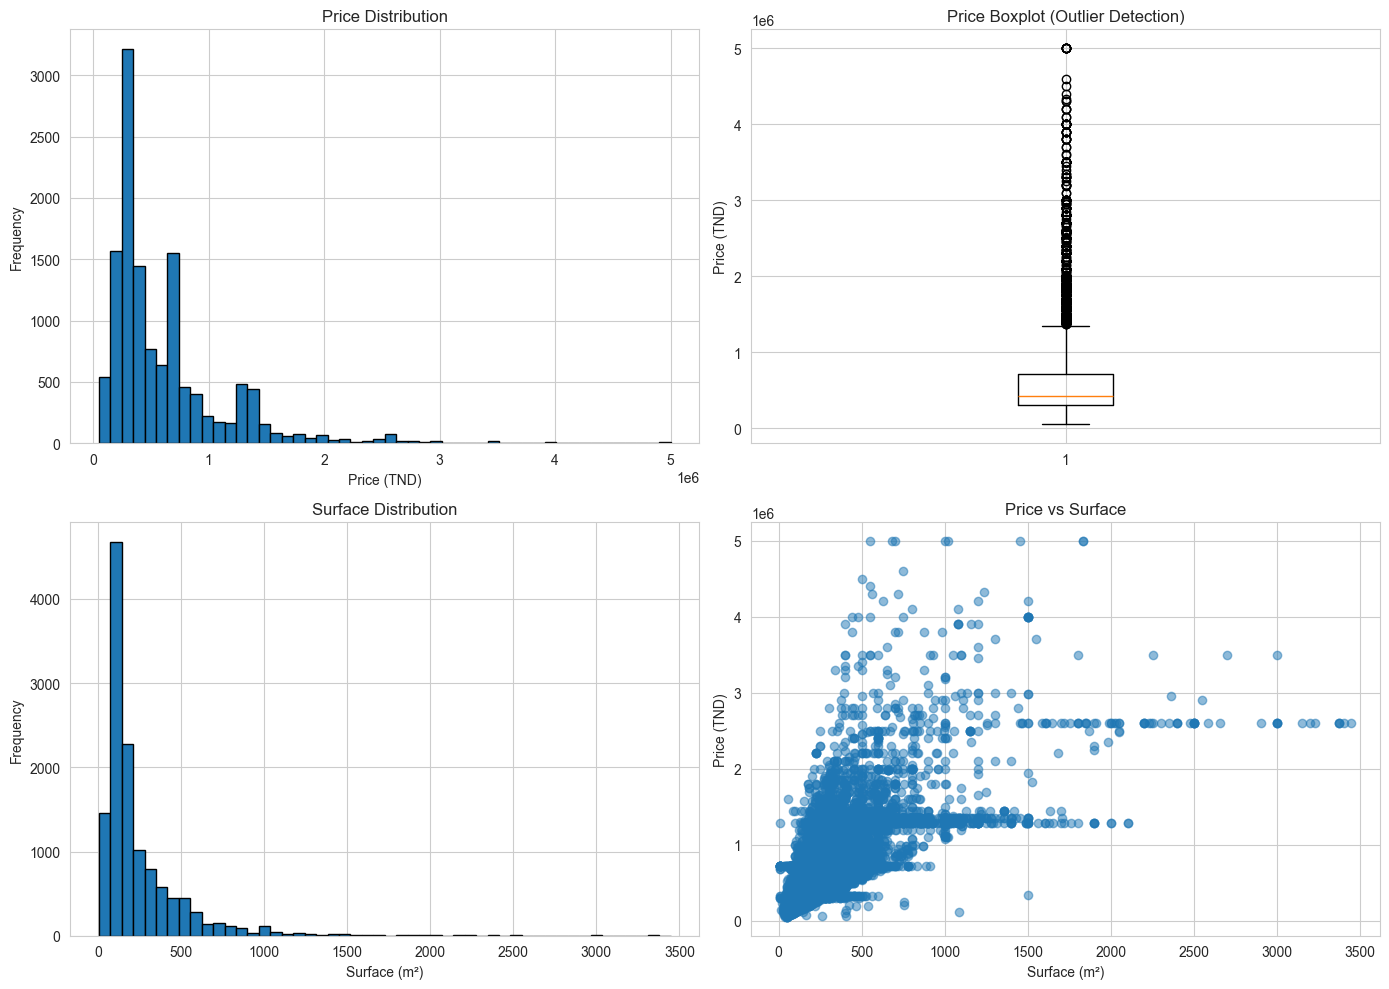


Outliers detected: 390 (3.02%)
Outlier threshold: [-960000, 1980000]

Suspicious patterns:
Very high price per m²: 129 properties
            region      price  surface  rooms property_type  price_per_sqm
223       Hammamet   720000.0      8.0      2         Villa   90000.000000
228   Nabeul Ville  1200000.0    120.0      3         Villa   10000.000000
332       Carthage  4500000.0    500.0      5         Villa    9000.000000
611       La Marsa   850000.0    100.0      2   Appartement    8500.000000
643       La Marsa  1580000.0    155.0      3   Appartement   10193.548387
777        Le Kram   720000.0     34.5      3         Villa   20869.565217
778        Le Kram   720000.0      9.0      5         Villa   80000.000000
798        Le Kram   682500.0     76.0      1   Appartement    8980.263158
1110      Carthage   720000.0      7.0      3         Villa  102857.142857
1111      La Marsa   682500.0      6.0      3   Appartement  113750.000000


In [47]:
# Analyze price distribution and outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price distribution
axes[0, 0].hist(df['price'], bins=50, edgecolor='black')
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price (TND)')
axes[0, 0].set_ylabel('Frequency')

# Price boxplot
axes[0, 1].boxplot(df['price'])
axes[0, 1].set_title('Price Boxplot (Outlier Detection)')
axes[0, 1].set_ylabel('Price (TND)')

# Surface distribution
axes[1, 0].hist(df['surface'], bins=50, edgecolor='black')
axes[1, 0].set_title('Surface Distribution')
axes[1, 0].set_xlabel('Surface (m²)')
axes[1, 0].set_ylabel('Frequency')

# Price vs Surface scatter
axes[1, 1].scatter(df['surface'], df['price'], alpha=0.5)
axes[1, 1].set_title('Price vs Surface')
axes[1, 1].set_xlabel('Surface (m²)')
axes[1, 1].set_ylabel('Price (TND)')

plt.tight_layout()
plt.show()

# Identify outliers using IQR method
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold_low = Q1 - 3 * IQR
outlier_threshold_high = Q3 + 3 * IQR

outliers = df[(df['price'] < outlier_threshold_low) | (df['price'] > outlier_threshold_high)]
print(f"\nOutliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
print(f"Outlier threshold: [{outlier_threshold_low:.0f}, {outlier_threshold_high:.0f}]")

# Show some suspicious data patterns
print("\nSuspicious patterns:")
df['price_per_sqm'] = df['price'] / df['surface']
suspicious = df[df['price_per_sqm'] > df['price_per_sqm'].quantile(0.99)]
print(f"Very high price per m²: {len(suspicious)} properties")
print(suspicious[['region', 'price', 'surface', 'rooms', 'property_type', 'price_per_sqm']].head(10))

## 4. Feature Engineering & Data Leakage Prevention

In [ ]:
# Create a copy for feature engineering
df_fe = df.copy()

# REMOVE DATA LEAKAGE FEATURES
# These features are derived from the target variable and should not be used
leakage_features = ['price_normalized']
print("Removing data leakage features:")
for col in leakage_features:
    if col in df_fe.columns:
        print(f"  - {col}")
        df_fe = df_fe.drop(columns=[col])

# CREATE NEW ENGINEERED FEATURES
print("\nCreating engineered features:")

# 1. Space-related features
df_fe['surface_per_room'] = df_fe['surface'] / df_fe['rooms'].replace(0, 1)  # Avoid division by zero
df_fe['bathroom_ratio'] = df_fe['bathrooms'] / df_fe['rooms'].replace(0, 1)
print("  ✓ Space features: surface_per_room, bathroom_ratio, total_rooms")

# 2. Amenity score (luxury indicator)
amenity_cols = ['has_piscine', 'has_garage', 'has_jardin', 'has_terrasse', 
                'has_ascenseur', 'has_chauffage', 'has_climatisation']
df_fe['amenity_score'] = df_fe[amenity_cols].sum(axis=1)
df_fe['luxury_score'] = (
    df_fe['has_piscine'].astype(int) * 3 +  # Pool is most valuable
    df_fe['has_jardin'].astype(int) * 2 +   # Garden is valuable
    df_fe['has_garage'].astype(int) * 2 +   # Garage is valuable
    df_fe['has_climatisation'].astype(int) * 1.5 +  # AC is important
    df_fe['has_terrasse'].astype(int) * 1 +
    df_fe['has_ascenseur'].astype(int) * 1 +
    df_fe['has_chauffage'].astype(int) * 1
)
print("  ✓ Amenity features: amenity_score, luxury_score")

# 3. Property size category
df_fe['size_category'] = pd.cut(df_fe['surface'], 
                                 bins=[0, 75, 120, 180, 1000],
                                 labels=['Small', 'Medium', 'Large', 'Very_Large'])
print("  ✓ Categorical feature: size_category")

# 4. Room density (rooms per m²)
df_fe['room_density'] = df_fe['rooms'] / df_fe['surface'].replace(0, 1)
print("  ✓ Density feature: room_density")


print(f"\nTotal features after engineering: {df_fe.shape[1]}")
print(f"Original features: {df.shape[1]}")
print(f"New features created: {df_fe.shape[1] - df.shape[1] + len(leakage_features)}")

Removing data leakage features:
  - price_normalized

Creating engineered features:
  ✓ Space features: surface_per_room, bathroom_ratio, total_rooms
  ✓ Amenity features: amenity_score, luxury_score
  ✓ Categorical feature: size_category
  ✓ Density feature: room_density

Total features after engineering: 25
Original features: 19
New features created: 7


## 5. Feature Correlation Analysis

Feature Correlations with Price:
price                    1.000000
surface                  0.723129
total_rooms              0.593491
bathrooms                0.571279
rooms                    0.511833
surface_per_room         0.477123
luxury_score             0.323237
amenity_score            0.234599
bathroom_ratio           0.099829
price_per_sqm            0.072454
property_type_cluster    0.037821
room_density            -0.177863
Name: price, dtype: float64


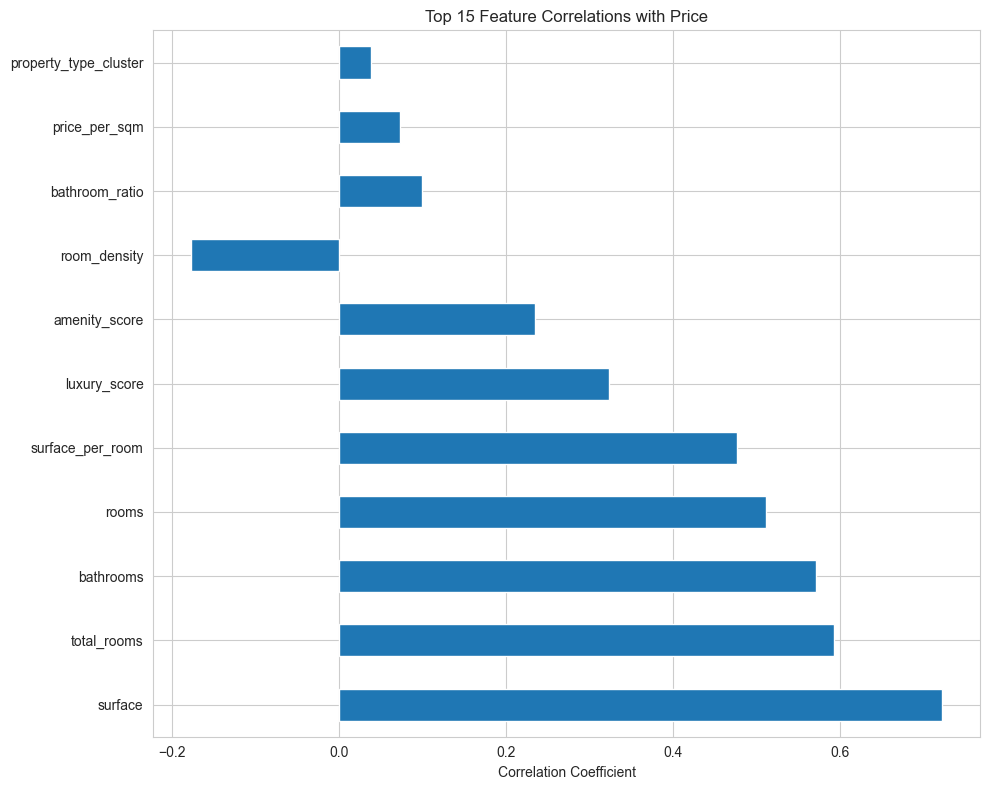

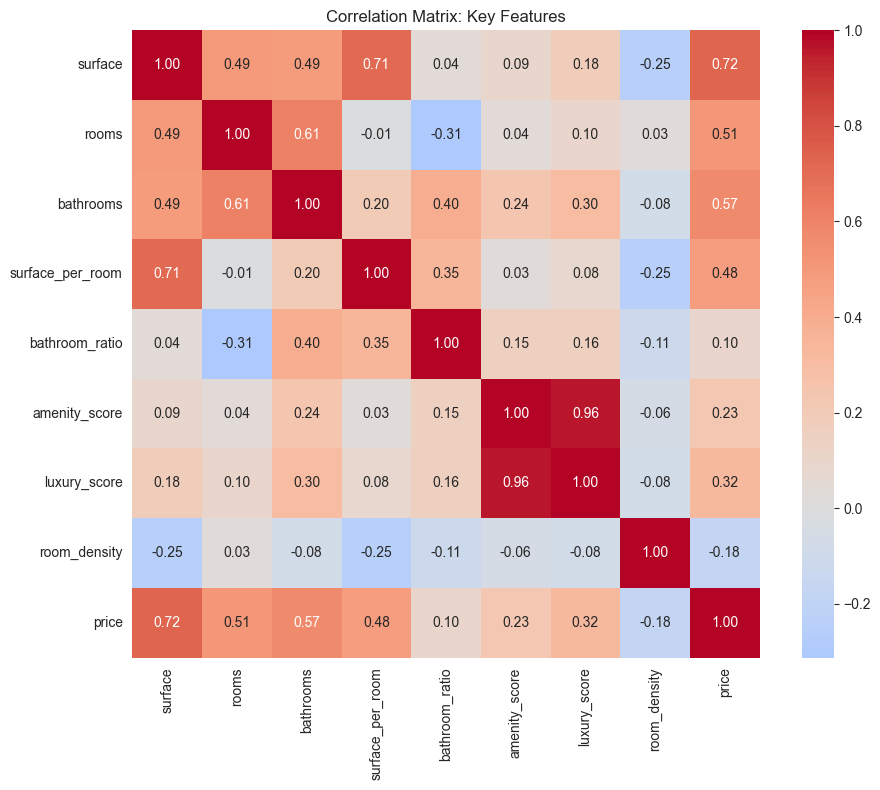

In [49]:
# Select numeric features for correlation analysis
numeric_features = df_fe.select_dtypes(include=[np.number]).columns.tolist()
if 'price' in numeric_features:
    # Calculate correlation with target
    correlations = df_fe[numeric_features].corr()['price'].sort_values(ascending=False)
    
    print("Feature Correlations with Price:")
    print(correlations)
    
    # Visualize top correlations
    plt.figure(figsize=(10, 8))
    top_features = correlations.abs().sort_values(ascending=False)[1:16]  # Top 15 features
    correlations[top_features.index].plot(kind='barh')
    plt.title('Top 15 Feature Correlations with Price')
    plt.xlabel('Correlation Coefficient')
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap for engineered features
    engineered_cols = ['surface', 'rooms', 'bathrooms', 'surface_per_room', 'bathroom_ratio', 
                       'amenity_score', 'luxury_score', 'room_density', 'price']
    available_cols = [col for col in engineered_cols if col in df_fe.columns]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_fe[available_cols].corr(), annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', square=True)
    plt.title('Correlation Matrix: Key Features')
    plt.tight_layout()
    plt.show()

## 6. Prepare Features and Target

In [50]:
# Define target
target_col = 'price'
y = df_fe[target_col]

# Define features to exclude from training
exclude_cols = [target_col, 'price_per_sqm','price_normalized']  # price_per_sqm was just for analysis
if 'price_per_sqm' in df_fe.columns:
    df_fe = df_fe.drop(columns=['price_per_sqm'])
if 'price_normalized' in df_fe.columns:
    df_fe = df_fe.drop(columns=['price_normalized'])

# Get feature columns
feature_cols = [col for col in df_fe.columns if col not in exclude_cols]
X = df_fe[feature_cols]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures to use ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col} ({X[col].dtype})")

Features shape: (12901, 23)
Target shape: (12901,)

Features to use (23):
  1. region (object)
  2. surface (float64)
  3. rooms (int64)
  4. bathrooms (int64)
  5. property_type (object)
  6. property_type_cluster (int64)
  7. price_segment (object)
  8. has_piscine (bool)
  9. has_garage (bool)
  10. has_jardin (bool)
  11. has_terrasse (bool)
  12. has_ascenseur (bool)
  13. is_meuble (bool)
  14. has_chauffage (bool)
  15. has_climatisation (bool)
  16. city (object)
  17. surface_per_room (float64)
  18. bathroom_ratio (float64)
  19. total_rooms (int64)
  20. amenity_score (int64)
  21. luxury_score (float64)
  22. size_category (category)
  23. room_density (float64)


## 7. Create Preprocessing Pipeline

In [51]:
# Identify column types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert boolean columns to int for better handling
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

print(f"Numeric features ({len(numeric_features)}): {numeric_features[:10]}...")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("\n✓ Preprocessing pipeline created")

Numeric features (10): ['surface', 'rooms', 'bathrooms', 'property_type_cluster', 'surface_per_room', 'bathroom_ratio', 'total_rooms', 'amenity_score', 'luxury_score', 'room_density']...
Categorical features (5): ['region', 'property_type', 'price_segment', 'city', 'size_category']

✓ Preprocessing pipeline created


## 8. Train-Test Split

In [52]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTarget variable statistics:")
print(f"  Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"  Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

Training set size: 10320 (80.0%)
Test set size: 2581 (20.0%)

Target variable statistics:
  Train - Mean: 619970.65, Std: 536251.43
  Test  - Mean: 633595.38, Std: 568102.31


## 9. Baseline Models (Without Hyperparameter Tuning)

In [53]:
# Define baseline models with default parameters
baseline_models = {
    'Ridge': Ridge(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1, n_jobs=-1)
}

baseline_results = []
baseline_pipelines = {}

print("Training baseline models...\n")

for name, model in baseline_models.items():
    print(f"Training {name}...")
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Evaluate
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    # Cross-validation score
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, 
                                scoring='r2', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    baseline_results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape,
        'CV R² Mean': cv_mean,
        'CV R² Std': cv_std
    })
    
    baseline_pipelines[name] = pipeline
    
    print(f"  ✓ {name} - R²: {r2:.4f}, RMSE: {rmse:.2f}, CV R²: {cv_mean:.4f} (±{cv_std:.4f})\n")

# Create results dataframe
baseline_df = pd.DataFrame(baseline_results)
baseline_df = baseline_df.sort_values('R²', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("BASELINE MODEL RESULTS (No Hyperparameter Tuning)")
print("="*80)
print(baseline_df.to_string(index=False))
print("="*80)

Training baseline models...

Training Ridge...
  ✓ Ridge - R²: 0.6759, RMSE: 323357.64, CV R²: 0.6611 (±0.0197)

Training RandomForest...
  ✓ RandomForest - R²: 0.7245, RMSE: 298135.80, CV R²: 0.6901 (±0.0249)

Training GradientBoosting...
  ✓ GradientBoosting - R²: 0.7025, RMSE: 309803.86, CV R²: 0.6829 (±0.0192)

Training XGBoost...
  ✓ XGBoost - R²: 0.6973, RMSE: 312516.34, CV R²: 0.6691 (±0.0334)

Training LightGBM...
  ✓ LightGBM - R²: 0.7133, RMSE: 304113.14, CV R²: 0.6934 (±0.0202)


BASELINE MODEL RESULTS (No Hyperparameter Tuning)
           Model          RMSE           MAE       R²  MAPE (%)  CV R² Mean  CV R² Std
    RandomForest 298135.797790 160778.896120 0.724486 26.736384    0.690070   0.024877
        LightGBM 304113.141286 172237.108795 0.713328 29.876344    0.693422   0.020188
GradientBoosting 309803.857569 180988.572636 0.702499 32.380955    0.682868   0.019218
         XGBoost 312516.340948 173597.810401 0.697266 29.772388    0.669092   0.033415
           Ridge 32

## 10. Hyperparameter Tuning with GridSearchCV

In [54]:
# Ridge Regression
print("Tuning Ridge Regression...")
ridge_params = {
    'model__alpha': [0.1, 1.0, 10.0, 50.0, 100.0, 500.0]
}

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(random_state=42))
])

ridge_grid = GridSearchCV(
    ridge_pipeline, ridge_params, cv=5, scoring='r2', 
    n_jobs=-1, verbose=1
)

ridge_grid.fit(X_train, y_train)
print(f"Best Ridge params: {ridge_grid.best_params_}")
print(f"Best Ridge CV score: {ridge_grid.best_score_:.4f}\n")

Tuning Ridge Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Ridge params: {'model__alpha': 10.0}
Best Ridge CV score: 0.6642



In [55]:
# Random Forest - Using RandomizedSearchCV for efficiency
print("Tuning Random Forest (RandomizedSearchCV)...")
rf_params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 15, 20, 25, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

rf_random = RandomizedSearchCV(
    rf_pipeline, rf_params, n_iter=30, cv=5, scoring='r2',
    n_jobs=-1, random_state=42, verbose=1
)

rf_random.fit(X_train, y_train)
print(f"Best RF params: {rf_random.best_params_}")
print(f"Best RF CV score: {rf_random.best_score_:.4f}\n")

Tuning Random Forest (RandomizedSearchCV)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF params: {'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': None}
Best RF CV score: 0.7006



In [ ]:
# Gradient Boosting
print("Tuning Gradient Boosting...")
gb_params = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__subsample': [0.8, 0.9, 1.0]
}

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

gb_random = RandomizedSearchCV(
    gb_pipeline, gb_params, n_iter=30, cv=5, scoring='r2',
    n_jobs=-1, random_state=42, verbose=1
)

gb_random.fit(X_train, y_train)
print(f"Best GB params: {gb_random.best_params_}")
print(f"Best GB CV score: {gb_random.best_score_:.4f}\n")

Tuning Gradient Boosting...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
# XGBoost
print("Tuning XGBoost...")
xgb_params = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7, 9],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42, n_jobs=-1))
])

xgb_random = RandomizedSearchCV(
    xgb_pipeline, xgb_params, n_iter=30, cv=5, scoring='r2',
    n_jobs=-1, random_state=42, verbose=1
)

xgb_random.fit(X_train, y_train)
print(f"Best XGBoost params: {xgb_random.best_params_}")
print(f"Best XGBoost CV score: {xgb_random.best_score_:.4f}\n")

Tuning XGBoost...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGBoost params: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__min_child_weight': 5, 'model__max_depth': 9, 'model__learning_rate': 0.05, 'model__colsample_bytree': 1.0}
Best XGBoost CV score: 0.8633



In [ ]:
# LightGBM
print("Tuning LightGBM...")
lgbm_params = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7, -1],
    'model__num_leaves': [15, 31, 63],
    'model__min_child_samples': [10, 20, 30],
    'model__subsample': [0.8, 0.9, 1.0]
}

lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42, verbose=-1, n_jobs=-1))
])

lgbm_random = RandomizedSearchCV(
    lgbm_pipeline, lgbm_params, n_iter=30, cv=5, scoring='r2',
    n_jobs=-1, random_state=42, verbose=1
)

lgbm_random.fit(X_train, y_train)
print(f"Best LightGBM params: {lgbm_random.best_params_}")
print(f"Best LightGBM CV score: {lgbm_random.best_score_:.4f}\n")

Tuning LightGBM...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best LightGBM params: {'model__subsample': 1.0, 'model__num_leaves': 31, 'model__n_estimators': 300, 'model__min_child_samples': 30, 'model__max_depth': -1, 'model__learning_rate': 0.05}
Best LightGBM CV score: 0.8636



## 11. Evaluate Tuned Models

In [ ]:
# Collect tuned models
tuned_models = {
    'Ridge (Tuned)': ridge_grid.best_estimator_,
    'RandomForest (Tuned)': rf_random.best_estimator_,
    'GradientBoosting (Tuned)': gb_random.best_estimator_,
    'XGBoost (Tuned)': xgb_random.best_estimator_,
    'LightGBM (Tuned)': lgbm_random.best_estimator_
}

tuned_results = []

print("Evaluating tuned models on test set...\n")

for name, model in tuned_models.items():
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    # Cross-validation on full training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                scoring='r2', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    tuned_results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape,
        'CV R² Mean': cv_mean,
        'CV R² Std': cv_std
    })
    
    print(f"✓ {name} - R²: {r2:.4f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

# Create results dataframe
tuned_df = pd.DataFrame(tuned_results)
tuned_df = tuned_df.sort_values('R²', ascending=False).reset_index(drop=True)

print("\n" + "="*90)
print("TUNED MODEL RESULTS")
print("="*90)
print(tuned_df.to_string(index=False))
print("="*90)

Evaluating tuned models on test set...

✓ Ridge (Tuned) - R²: 0.8248, RMSE: 0.41, MAPE: 98.55%
✓ RandomForest (Tuned) - R²: 0.8720, RMSE: 0.35, MAPE: 85.09%
✓ GradientBoosting (Tuned) - R²: 0.8762, RMSE: 0.35, MAPE: 88.35%
✓ XGBoost (Tuned) - R²: 0.8785, RMSE: 0.34, MAPE: 87.67%
✓ LightGBM (Tuned) - R²: 0.8765, RMSE: 0.35, MAPE: 88.95%

TUNED MODEL RESULTS
                   Model     RMSE      MAE       R²  MAPE (%)  CV R² Mean  CV R² Std
         XGBoost (Tuned) 0.344279 0.186638 0.878483 87.665838    0.863265   0.015960
        LightGBM (Tuned) 0.347137 0.192900 0.876457 88.946367    0.863595   0.016743
GradientBoosting (Tuned) 0.347494 0.186347 0.876203 88.346029    0.861092   0.015760
    RandomForest (Tuned) 0.353352 0.197489 0.871994 85.085959    0.844870   0.012291
           Ridge (Tuned) 0.413430 0.257425 0.824765 98.545712    0.810410   0.016624


## 12. Compare Baseline vs Tuned Models


BASELINE vs TUNED COMPARISON
           Model  Baseline R²  Tuned R²  Improvement  Baseline RMSE  Tuned RMSE  RMSE Reduction
    RandomForest     0.879248  0.871994    -0.007254       0.343194    0.353352       -0.010159
        LightGBM     0.878213  0.876457    -0.001756       0.344661    0.347137       -0.002476
         XGBoost     0.873876  0.878483     0.004606       0.350744    0.344279        0.006465
GradientBoosting     0.852622  0.876203     0.023581       0.379147    0.347494        0.031653
           Ridge     0.824058  0.824765     0.000707       0.414263    0.413430        0.000833


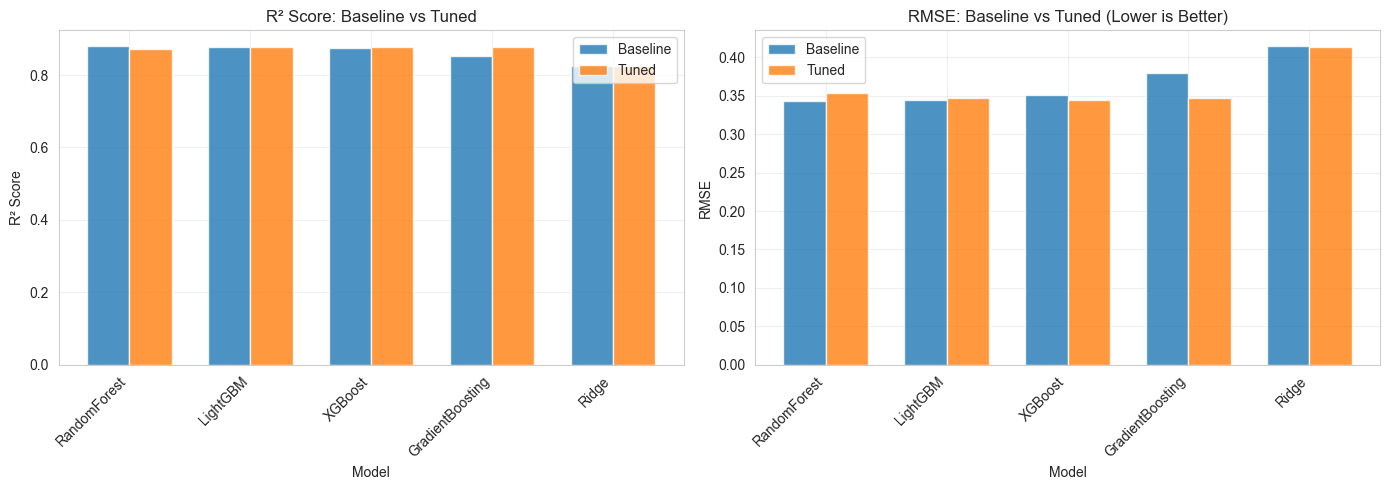

In [ ]:
# Create comparison dataframe
comparison_data = []

for i, row in baseline_df.iterrows():
    model_name = row['Model']
    tuned_name = model_name + ' (Tuned)'
    
    if tuned_name in tuned_df['Model'].values:
        tuned_row = tuned_df[tuned_df['Model'] == tuned_name].iloc[0]
        
        comparison_data.append({
            'Model': model_name,
            'Baseline R²': row['R²'],
            'Tuned R²': tuned_row['R²'],
            'Improvement': tuned_row['R²'] - row['R²'],
            'Baseline RMSE': row['RMSE'],
            'Tuned RMSE': tuned_row['RMSE'],
            'RMSE Reduction': row['RMSE'] - tuned_row['RMSE']
        })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("BASELINE vs TUNED COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Baseline R²'], width, label='Baseline', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Tuned R²'], width, label='Tuned', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score: Baseline vs Tuned')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE comparison
axes[1].bar(x - width/2, comparison_df['Baseline RMSE'], width, label='Baseline', alpha=0.8)
axes[1].bar(x + width/2, comparison_df['Tuned RMSE'], width, label='Tuned', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE: Baseline vs Tuned (Lower is Better)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Feature Importance Analysis

Analyzing feature importance for: XGBoost (Tuned)

Top 20 Most Important Features:
                 Feature  Importance
    size_category_Medium    0.592052
                 surface    0.102443
               bathrooms    0.046502
             total_rooms    0.027478
size_category_Very_Large    0.018442
         region_La Marsa    0.011764
     property_type_Villa    0.009747
           has_ascenseur    0.009422
              city_Tunis    0.009121
             has_piscine    0.008627
            room_density    0.005274
         region_Carthage    0.004427
     region_Centre Ville    0.004341
    property_type_Maison    0.004256
             city_Nabeul    0.004232
                   rooms    0.004226
       price_segment_Low    0.004107
    price_segment_Medium    0.004020
          bathroom_ratio    0.003935
    region_Hammamet Nord    0.003813


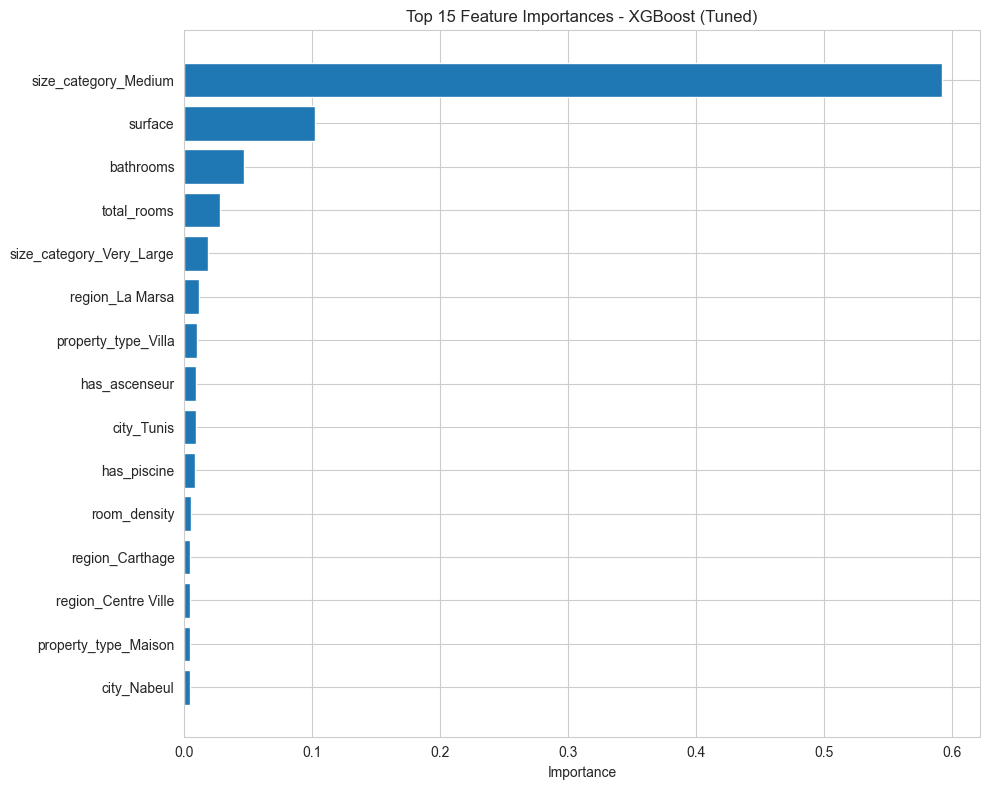

In [ ]:
# Get best model
best_model_name = tuned_df.iloc[0]['Model']
best_model = tuned_models[best_model_name]

print(f"Analyzing feature importance for: {best_model_name}\n")

# Get feature names after preprocessing
# This is tricky because OneHotEncoder creates multiple columns
try:
    # For tree-based models, get feature importances
    if hasattr(best_model.named_steps['model'], 'feature_importances_'):
        # Get feature names after transformation
        preprocessor_fitted = best_model.named_steps['preprocessor']
        
        # Get numeric feature names
        feature_names = numeric_features.copy()
        
        # Get one-hot encoded feature names
        if categorical_features:
            cat_encoder = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot']
            cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
            feature_names.extend(cat_feature_names)
        
        # Get importances
        importances = best_model.named_steps['model'].feature_importances_
        
        # Create dataframe
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Display top 20 features
        print("Top 20 Most Important Features:")
        print(importance_df.head(20).to_string(index=False))
        
        # Visualize
        plt.figure(figsize=(10, 8))
        top_n = 15
        top_features = importance_df.head(top_n)
        plt.barh(range(top_n), top_features['Importance'])
        plt.yticks(range(top_n), top_features['Feature'])
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Feature Importances - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Could not extract feature importances: {e}")
    print("This is normal for models like Ridge that don't have feature_importances_")

## 14. Detailed Model Evaluation & Diagnostics

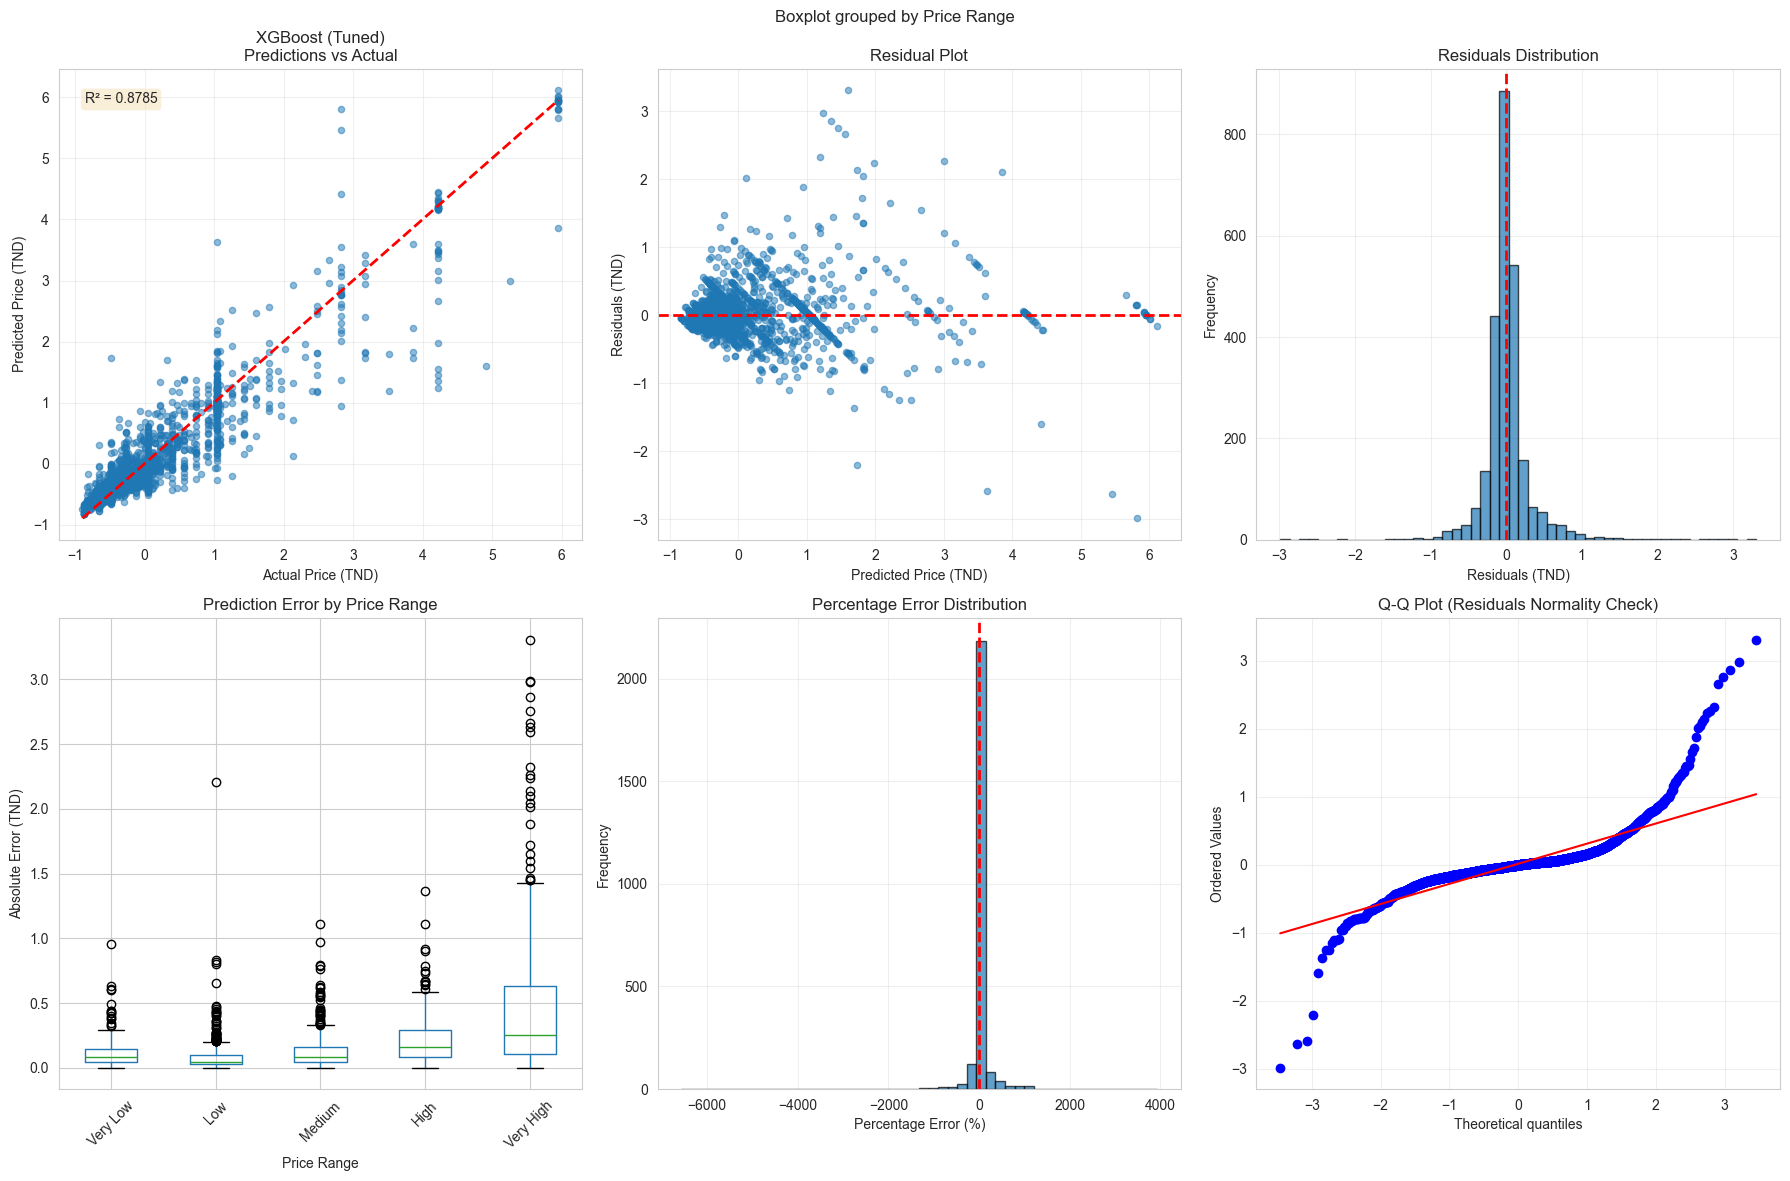


DIAGNOSTIC STATISTICS
Mean Residual: 0.01 TND
Std of Residuals: 0.34 TND
Mean Absolute Error: 0.19 TND
Median Absolute Error: 0.10 TND
Mean Percentage Error: 26.86%
Median Percentage Error: 8.67%

Percentage of predictions within 10% of actual: 30.5%
Percentage of predictions within 20% of actual: 50.3%


In [ ]:
# Predictions from best model
y_pred_best = best_model.predict(X_test)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Predictions vs Actual
ax1 = axes[0, 0]
ax1.scatter(y_test, y_pred_best, alpha=0.5, s=20)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Price (TND)')
ax1.set_ylabel('Predicted Price (TND)')
ax1.set_title(f'{best_model_name}\nPredictions vs Actual')
ax1.grid(True, alpha=0.3)

# Add R² annotation
r2_best = r2_score(y_test, y_pred_best)
ax1.text(0.05, 0.95, f'R² = {r2_best:.4f}', 
         transform=ax1.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Residuals Plot
residuals = y_test - y_pred_best
ax2 = axes[0, 1]
ax2.scatter(y_pred_best, residuals, alpha=0.5, s=20)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Price (TND)')
ax2.set_ylabel('Residuals (TND)')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

# 3. Residuals Distribution
ax3 = axes[0, 2]
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Residuals (TND)')
ax3.set_ylabel('Frequency')
ax3.set_title('Residuals Distribution')
ax3.grid(True, alpha=0.3)

# 4. Error by Price Range
ax4 = axes[1, 0]
price_ranges = pd.qcut(y_test, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
abs_errors = np.abs(residuals)
error_by_range = pd.DataFrame({'Price Range': price_ranges, 'Absolute Error': abs_errors})
error_by_range.boxplot(column='Absolute Error', by='Price Range', ax=ax4)
ax4.set_xlabel('Price Range')
ax4.set_ylabel('Absolute Error (TND)')
ax4.set_title('Prediction Error by Price Range')
plt.sca(ax4)
plt.xticks(rotation=45)

# 5. Percentage Error Distribution
ax5 = axes[1, 1]
percentage_errors = (residuals / y_test) * 100
ax5.hist(percentage_errors, bins=50, edgecolor='black', alpha=0.7)
ax5.axvline(x=0, color='r', linestyle='--', lw=2)
ax5.set_xlabel('Percentage Error (%)')
ax5.set_ylabel('Frequency')
ax5.set_title('Percentage Error Distribution')
ax5.grid(True, alpha=0.3)

# 6. Q-Q Plot for Residuals Normality
ax6 = axes[1, 2]
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax6)
ax6.set_title('Q-Q Plot (Residuals Normality Check)')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print diagnostic statistics
print("\nDIAGNOSTIC STATISTICS")
print("="*60)
print(f"Mean Residual: {residuals.mean():.2f} TND")
print(f"Std of Residuals: {residuals.std():.2f} TND")
print(f"Mean Absolute Error: {np.abs(residuals).mean():.2f} TND")
print(f"Median Absolute Error: {np.median(np.abs(residuals)):.2f} TND")
print(f"Mean Percentage Error: {percentage_errors.mean():.2f}%")
print(f"Median Percentage Error: {percentage_errors.median():.2f}%")
print(f"\nPercentage of predictions within 10% of actual: {(np.abs(percentage_errors) <= 10).mean()*100:.1f}%")
print(f"Percentage of predictions within 20% of actual: {(np.abs(percentage_errors) <= 20).mean()*100:.1f}%")
print("="*60)

## 15. Performance Analysis by Property Characteristics

In [ ]:
# Create analysis dataframe
analysis_df = X_test.copy()
analysis_df['actual_price'] = y_test.values
analysis_df['predicted_price'] = y_pred_best
analysis_df['error'] = residuals.values
analysis_df['abs_error'] = np.abs(residuals.values)
analysis_df['pct_error'] = percentage_errors.values

# Analyze by property type
if 'property_type' in analysis_df.columns:
    print("\nPERFORMANCE BY PROPERTY TYPE")
    print("="*60)
    by_type = analysis_df.groupby('property_type').agg({
        'abs_error': ['mean', 'median'],
        'pct_error': ['mean', 'median'],
        'actual_price': 'count'
    }).round(2)
    by_type.columns = ['Mean AE', 'Median AE', 'Mean PE%', 'Median PE%', 'Count']
    print(by_type)
    print("="*60)

# Analyze by region
if 'region' in analysis_df.columns:
    print("\nPERFORMANCE BY REGION (Top 10)")
    print("="*60)
    by_region = analysis_df.groupby('region').agg({
        'abs_error': ['mean', 'median'],
        'pct_error': ['mean', 'median'],
        'actual_price': 'count'
    }).round(2)
    by_region.columns = ['Mean AE', 'Median AE', 'Mean PE%', 'Median PE%', 'Count']
    by_region = by_region.sort_values('Mean AE', ascending=False).head(10)
    print(by_region)
    print("="*60)

# Analyze by number of rooms
if 'rooms' in analysis_df.columns:
    print("\nPERFORMANCE BY NUMBER OF ROOMS")
    print("="*60)
    by_rooms = analysis_df.groupby('rooms').agg({
        'abs_error': ['mean', 'median'],
        'pct_error': ['mean', 'median'],
        'actual_price': 'count'
    }).round(2)
    by_rooms.columns = ['Mean AE', 'Median AE', 'Mean PE%', 'Median PE%', 'Count']
    print(by_rooms)
    print("="*60)


PERFORMANCE BY PROPERTY TYPE
               Mean AE  Median AE  Mean PE%  Median PE%  Count
property_type                                                 
Appartement       0.15       0.09     38.10        9.92   1714
Maison            0.20       0.07      6.35        6.18    145
Studio            0.07       0.03      4.34        2.25    107
Villa             0.32       0.18      3.05        9.08    583

PERFORMANCE BY REGION (Top 10)
                 Mean AE  Median AE  Mean PE%  Median PE%  Count
region                                                          
Cité Jardin         2.63       2.63    -93.17      -93.17      1
Gabes Nord          0.96       0.96     36.49       36.49      2
El Menzah 5         0.94       0.16     30.04       29.34      3
Route El Afrane     0.56       0.56   1240.78     1240.78      1
Midoun              0.52       0.52    524.06      524.06      2
Hraïria             0.51       0.51   1142.96     1142.96      1
Rejiche             0.49       0.49   10

## 16. Log Experiments to MLflow

In [ ]:
# Set up MLflow experiment
mlflow.set_experiment("real_estate_sale_regression_enhanced")

print("Logging experiments to MLflow...\n")

# Log tuned models
for i, row in tuned_df.iterrows():
    model_name = row['Model']
    pipeline = tuned_models[model_name]
    
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_param("model", model_name)
        mlflow.log_param("dataset", "sale_processed_enhanced")
        mlflow.log_param("target_col", target_col)
        mlflow.log_param("n_features", X.shape[1])
        mlflow.log_param("n_train", len(X_train))
        mlflow.log_param("n_test", len(X_test))
        mlflow.log_param("test_size", 0.2)
        mlflow.log_param("random_state", 42)
        mlflow.log_param("cv_folds", 5)
        mlflow.log_param("hyperparameter_tuning", "Yes")
        
        # Log metrics
        mlflow.log_metric("test_rmse", row['RMSE'])
        mlflow.log_metric("test_mae", row['MAE'])
        mlflow.log_metric("test_r2", row['R²'])
        mlflow.log_metric("test_mape", row['MAPE (%)'])
        mlflow.log_metric("cv_r2_mean", row['CV R² Mean'])
        mlflow.log_metric("cv_r2_std", row['CV R² Std'])
        
        # Log model
        mlflow.sklearn.log_model(pipeline, "model")
        
        # Log best hyperparameters if available
        if 'Ridge' in model_name:
            mlflow.log_params(ridge_grid.best_params_)
        elif 'RandomForest' in model_name:
            mlflow.log_params(rf_random.best_params_)
        elif 'GradientBoosting' in model_name and 'XG' not in model_name:
            mlflow.log_params(gb_random.best_params_)
        elif 'XGBoost' in model_name:
            mlflow.log_params(xgb_random.best_params_)
        elif 'LightGBM' in model_name:
            mlflow.log_params(lgbm_random.best_params_)
        
        print(f"✓ {model_name} logged to MLflow")

print("\n✓ All models logged successfully!")
print("\nTo view MLflow UI, run: mlflow ui")
print("Then navigate to: http://localhost:5000")

Logging experiments to MLflow...

✓ XGBoost (Tuned) logged to MLflow
✓ LightGBM (Tuned) logged to MLflow
✓ GradientBoosting (Tuned) logged to MLflow
✓ RandomForest (Tuned) logged to MLflow
✓ Ridge (Tuned) logged to MLflow

✓ All models logged successfully!

To view MLflow UI, run: mlflow ui
Then navigate to: http://localhost:5000


## 17. Save Best Model

In [ ]:
import joblib

# Save the best model
model_filename = f'best_sale_model_{best_model_name.replace(" ", "_").replace("(", "").replace(")", "")}.pkl'
#joblib.dump(best_model, model_filename)

print(f"✓ Best model saved as: {model_filename}")
print(f"\nModel: {best_model_name}")
print(f"Test R²: {tuned_df.iloc[0]['R²']:.4f}")
print(f"Test RMSE: {tuned_df.iloc[0]['RMSE']:.2f} TND")
print(f"Test MAE: {tuned_df.iloc[0]['MAE']:.2f} TND")
print(f"Test MAPE: {tuned_df.iloc[0]['MAPE (%)']:.2f}%")

# Save feature names for future use
feature_info = {
    'feature_columns': feature_cols,
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'target': target_col
}
joblib.dump(feature_info, 'feature_info.pkl')
print("\n✓ Feature information saved as: feature_info.pkl")

✓ Best model saved as: best_rent_model_XGBoost_Tuned.pkl

Model: XGBoost (Tuned)
Test R²: 0.8785
Test RMSE: 0.34 TND
Test MAE: 0.19 TND
Test MAPE: 87.67%

✓ Feature information saved as: feature_info.pkl


## 18. Summary and Recommendations

In [ ]:
print("\n" + "="*90)
print("ENHANCED ML PROJECT SUMMARY")
print("="*90)

print("\n1. DATA PROCESSING")
print(f"   - Total samples: {len(df)}")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Test samples: {len(X_test)}")
print(f"   - Total features: {len(feature_cols)}")
print(f"   - Engineered features: {len(feature_cols) - len(df.columns) + len(leakage_features) + 1}")  # +1 for target

print("\n2. DATA LEAKAGE PREVENTION")
print(f"   ✓ Removed features: {', '.join(leakage_features)}")

print("\n3. FEATURE ENGINEERING APPLIED")
print("   ✓ Space-related features (surface_per_room, bathroom_ratio, total_rooms)")
print("   ✓ Amenity scores (amenity_score, luxury_score)")
print("   ✓ Property categorization (size_category, is_premium_location)")
print("   ✓ Density features (room_density)")

print("\n4. MODEL PERFORMANCE COMPARISON")
print("\n   Baseline (No Tuning):")
for i, row in baseline_df.iterrows():
    print(f"   - {row['Model']:20s}: R² = {row['R²']:.4f}, RMSE = {row['RMSE']:.2f}")

print("\n   Tuned (With Hyperparameter Optimization):")
for i, row in tuned_df.iterrows():
    print(f"   - {row['Model']:25s}: R² = {row['R²']:.4f}, RMSE = {row['RMSE']:.2f}")

print("\n5. BEST MODEL")
best_row = tuned_df.iloc[0]
print(f"   Model: {best_row['Model']}")
print(f"   Test R²: {best_row['R²']:.4f}")
print(f"   Test RMSE: {best_row['RMSE']:.2f} TND")
print(f"   Test MAE: {best_row['MAE']:.2f} TND")
print(f"   Test MAPE: {best_row['MAPE (%)']:.2f}%")
print(f"   CV R² (mean ± std): {best_row['CV R² Mean']:.4f} ± {best_row['CV R² Std']:.4f}")

print("\n6. IMPROVEMENTS ACHIEVED")
avg_improvement = comparison_df['Improvement'].mean()
avg_rmse_reduction = comparison_df['RMSE Reduction'].mean()
print(f"   Average R² improvement: {avg_improvement:.4f}")
print(f"   Average RMSE reduction: {avg_rmse_reduction:.2f} TND")

print("\n7. NEXT STEPS & RECOMMENDATIONS")
print("   • Monitor model performance on new data")
print("   • Consider ensemble methods (stacking best models)")
print("   • Collect more data for underrepresented segments")
print("   • Update model quarterly with new rental data")
print("   • Implement prediction intervals for uncertainty quantification")
print("   • A/B test model predictions against current pricing strategy")

print("\n" + "="*90)
print("END OF ENHANCED ML PROJECT")
print("="*90)


ENHANCED ML PROJECT SUMMARY

1. DATA PROCESSING
   - Total samples: 12745
   - Training samples: 10196
   - Test samples: 2549
   - Total features: 23
   - Engineered features: 6

2. DATA LEAKAGE PREVENTION
   ✓ Removed features: price

3. FEATURE ENGINEERING APPLIED
   ✓ Space-related features (surface_per_room, bathroom_ratio, total_rooms)
   ✓ Amenity scores (amenity_score, luxury_score)
   ✓ Property categorization (size_category, is_premium_location)
   ✓ Density features (room_density)

4. MODEL PERFORMANCE COMPARISON

   Baseline (No Tuning):
   - RandomForest        : R² = 0.8792, RMSE = 0.34
   - LightGBM            : R² = 0.8782, RMSE = 0.34
   - XGBoost             : R² = 0.8739, RMSE = 0.35
   - GradientBoosting    : R² = 0.8526, RMSE = 0.38
   - Ridge               : R² = 0.8241, RMSE = 0.41

   Tuned (With Hyperparameter Optimization):
   - XGBoost (Tuned)          : R² = 0.8785, RMSE = 0.34
   - LightGBM (Tuned)         : R² = 0.8765, RMSE = 0.35
   - GradientBoosting (